In [1]:
# standard python utilities
import os
from os.path import basename, dirname,join
import sys
import glob
import pandas as pd
import numpy as np


# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import geopandas as gpd




In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
    
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

fig_dir = proj_dir+'/Streambed_seepage/figures/'
hob_dir = join(gwfm_dir, 'HOB_data')
sfr_dir = gwfm_dir+'/SFR_data/'

py_dir = doc_dir +'GitHub/CosumnesRiverRecharge/python_utilities/'

out_dir = join(proj_dir, 'output')
fig_dir = join(proj_dir, 'figures')

In [3]:
flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
#     sys.path.append(flopy_dir)
    sys.path.insert(0, flopy_dir)
# sys.path
import flopy 

In [4]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'

tprogs_id = '' # original tprogs with conditioning data in output tsim
# tprogs_id = '_no_conditioning'

In [5]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/'
model_ws = loadpth+'Permeameter_for_velocity' + tprogs_id

In [6]:
# name = 'MF.nam'
# # name = 'MF_child.nam'
# m = flopy.modflow.Modflow.load(name, model_ws=model_ws, 
#                                 exe_name='mf2005', version='mf2005')


In [7]:
# dem data for cropping above land surface
dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_mean.tsv') #linear

In [8]:
# regional model grid
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
# local model grid
grid_match = gpd.read_file(join(proj_dir, 'GIS','grid_match.shp'))


In [9]:
import numpy as np

import pyvista as pv
from pyvista import examples

In [10]:
pv.set_jupyter_backend('trame')


C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\trame\ui\__init__.py:1: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('trame.ui')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\pkg_resources\__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('trame')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\trame_vuetify\widgets\vuetify.py:495: DeprecationWarning: invalid escape sequence '\|'
  "

In [11]:


tprogs_fxn_dir = doc_dir +'/GitHub/CosumnesRiverRecharge/tprogs_utilities'
if tprogs_fxn_dir not in sys.path:
    sys.path.append(tprogs_fxn_dir)
# import cleaning functions for tprogs
import tprogs_cleaning as tc


## TPROGs coarse connectivity

In [12]:
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final' + tprogs_id+'/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')
# tprogs_files

In [13]:
tprogs_info = [80, -80, 320]


In [89]:
params = pd.read_csv(model_ws+'/ZonePropertiesInitial.csv', index_col='Zone')
# convert from m/s to m/d
params['K_m_d'] = params.K_m_s * 86400   


In [135]:

t=0
tprogs_line = np.loadtxt(tprogs_files[t])
tprogs_arr = np.reshape(tprogs_line, (320, 100,230))
# switch conditioning data to be consistent
tprogs_arr = np.where(tprogs_arr<0, tprogs_arr*-1, tprogs_arr)

K, Sy, Ss= tc.int_to_param(tprogs_arr, params)
K_r = np.copy(K)


In [136]:
nrow,ncol = grid_match.row.max(), grid_match.column.max()
dem_data_p = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_mean.tsv')

dem_data = np.zeros((nrow,ncol))
dem_data[grid_match.row-1, grid_match.column-1] = dem_data_p[grid_match.p_row-1, grid_match.p_column-1]


<>:2: DeprecationWarning: invalid escape sequence '\D'
<>:2: DeprecationWarning: invalid escape sequence '\D'
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_6020\4243163556.py:2: DeprecationWarning: invalid escape sequence '\D'
  dem_data_p = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_mean.tsv')


In [137]:
# tprogs_arr_local = np.zeros((320, nrow, ncol))
# tprogs_arr_local[:, grid_match.row-1, grid_match.column-1] = tprogs_arr[:, grid_match.p_row-1, grid_match.p_column-1]
K_local = np.zeros((320, nrow, ncol))
K_local[:, grid_match.row-1, grid_match.column-1] = K_r[:, grid_match.p_row-1, grid_match.p_column-1]

# crop vertically to model top and bottom maximum extent
strt_layer = int((80 - dem_data.max())*2) # includes max extent of trpogs
strt_layer = int((80 - dem_data.min())*2) # includes layer with all tprogs cells

min_elev = int(np.floor((dem_data-40).min()))
end_layer = int((80 - min_elev)*2)
K_local = K_local[strt_layer:end_layer]

In [43]:
all_model_ws = 'F:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage/parallel_oneto_denier_2014_2018'


In [19]:
base_model_ws =  'F:/WRDAPP/GWFlowModel/Cosumnes/Stream_seepage/oneto_denier_2014_2018'

load_only=['DIS','UPW','BAS6']
m = flopy.modflow.Modflow.load('MF.nam', model_ws= base_model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt',
                              load_only = load_only
                              )


In [20]:
botm = m.dis.botm.array

nlay = m.dis.nlay
# nrow = m.dis.nrow
# ncol = m.dis.ncol
upscale = 8

In [66]:
# upscaled tprogs
folder = 'realization'+ str(t).zfill(3)
# update model workspace so outputs to right directory
model_ws = join(all_model_ws, folder)
tfn = join(model_ws, 'tprogs_local.csv')
tprogs_local = np.reshape(np.loadtxt(tfn),(tprogs_info[-1], nrow, ncol))


In [138]:
params = pd.read_csv(model_ws+'/ZonePropertiesInitial.csv', index_col='Zone')
# convert from m/s to m/d
params['K_m_d'] = params.K_m_s * 86400   
K, Sy, Ss,porosity = tc.int_to_param(tprogs_local, params, porosity=True)

hk = np.zeros(botm.shape)
vka = np.zeros(botm.shape)
sy = np.zeros(botm.shape)
ss = np.zeros(botm.shape)
por = np.zeros(botm.shape)

top = np.copy(m.dis.top.array)
bot1 = np.copy(botm[-1,:,:])
# tprogs_info = ()
from scipy.stats import hmean, gmean

# I need to verify if a flattening layer is needed (e.g., variable thickness to maintain TPROGs connectivity)
# pull out the TPROGS data for the corresponding depths
K_c = tc.get_tprogs_for_elev(K, top, bot1,tprogs_info)
Ss_c = tc.get_tprogs_for_elev(Ss, top, bot1,tprogs_info)
Sy_c = tc.get_tprogs_for_elev(Sy, top, bot1,tprogs_info)
n_c = tc.get_tprogs_for_elev(porosity, top, bot1,tprogs_info)

# upscale as preset
for k in np.arange(0,nlay):
    hk[k,:] = np.mean(K_c[upscale*k:upscale*(k+1)], axis=0)
    vka[k,:] = hmean(K_c[upscale*k:upscale*(k+1)], axis=0)
    ss[k,:] = np.mean(Ss_c[upscale*k:upscale*(k+1)], axis=0)
    sy[k,:] = np.mean(Sy_c[upscale*k:upscale*(k+1)], axis=0)
    por[k,:] = np.mean(n_c[upscale*k:upscale*(k+1)], axis=0)

- K to K_local aligns as expected
- the mismatch is with the un upscaled data keeping original layers and the upscaled data has different layers sampled based on elevation at the dem to 40m
- after changing the top layer to be in line with the tprogs top there was more consistency
- it looks like it is worth checking whether 0.5 upscaling would work

In [139]:
K[strt_layer:end_layer].shape, K_local.shape

((82, 75, 83), (82, 75, 83))

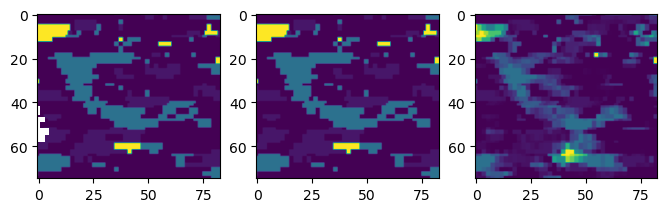

In [140]:
fig,ax = plt.subplots(1,3, figsize=(8,6))
ax[0].imshow(K[strt_layer:end_layer][0])
ax[1].imshow(K_local[0])
ax[2].imshow(hk[0,:,:])


In [70]:
def mfarr2grid(arr, dz = 0.5):
    grid = pv.UniformGrid()
    # Set the grid dimensions: shape because we want to inject our values on the
    #   POINT data
    # I have to add 1 to each dimension to have it be built on the cells
    nz, ny, nx = arr.shape
    grid.dimensions = [ny+1, nx+1, nz+1]
    # real origin, but incorrect because of no rotation
#     grid.origin = (645500.0, 4227700.0, -80) # bottom left corner of the dataset
# simple origin that allows easier data output cleaning
    grid.origin = (0, 0, -80) # bottom left corner of the dataset
    grid.spacing = (200,200, dz)
    arr_in = np.moveaxis(arr,0,2).flatten(order='F').astype(int)
    # grid.point_data["facies"] = arr_in
    grid.cell_data["facies"] = arr_in
    return(grid)


In [34]:
def grid_plt(grid, fig_nam):
    plotter = pv.Plotter(notebook=False, lighting=None, off_screen=True) # 
    plotter.background_color='white'
    mesh = plotter.add_mesh(grid, scalars="facies", cmap='viridis',
#                      show_edges=True, 
                    )
#     axes = pv.Axes(show_actor=True, actor_scale=2.0, line_width=5)
    plotter.set_scale(1, 1, 50)
# found ideal position by manual adjustment
    mesh.rotate_z(90)
    mesh.rotate_x(20)
    mesh.rotate_y(10)
#     grid = plotter.show_grid()
    print(join(fig_dir, fig_nam + '.png'))
    plotter.show(screenshot=join(fig_dir, fig_nam + '.png'))
    # plotting looks the same when built on cells instead of points
    
# grid_plt(grid, 'tprogs_facies')


## Create and plot TPROGs grid

In [71]:
# grid = mfarr2grid(tprogs_arr)


In [141]:
grid = mfarr2grid(K_local)
grid_plt(grid, 'tprogs_K')


C:\Users\ajcalder/Box/research_cosumnes/GWFlowModel/Oneto_Denier/figures\tprogs_K.png


In [147]:
# K[strt_layer-1:end_layer]

In [149]:
# plot the file loaded from tprogs, add 1 to avoid any nan values
grid = mfarr2grid(K[strt_layer+1:end_layer], dz = 0.5)

grid_plt(grid, 'preprocessed_K_local')


C:\Users\ajcalder/Box/research_cosumnes/GWFlowModel/Oneto_Denier/figures\preprocessed_K_local.png


In [143]:
grid = mfarr2grid(hk, dz = 4)

grid_plt(grid, 'hk_upscaled_8')



C:\Users\ajcalder/Box/research_cosumnes/GWFlowModel/Oneto_Denier/figures\hk_upscaled_8.png


# Create and plot Connec3d data

In [80]:
# dem data for cropping above land surface
dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_mean.tsv')

model_ws = loadpth+'Connec3d' + tprogs_id

cco_in = np.loadtxt(join(model_ws, 'r000.CCO'))
# reshape to array format
cco = np.reshape(cco_in, (320, 100,230))

In [81]:
def get_cco_vert(cco, dem_data):
    z,y,x = np.where(cco>0)
    val = cco[z,y,x]
    # np.transpose((z,y,x,val))
    df = pd.DataFrame(np.transpose((z,y,x,val)),columns=['z','y','x','cc'])
    # find ground elevation at each connected point
    df['dem'] = dem_data[df.y.astype(int),df.x.astype(int)]
    # calculate elevation from tprogs layer
    df['elev'] = 80-z*0.5
    # check whether max is above land and below
    df['above_gse'] = (df.elev > df.dem) 
    df['below_30'] = (df.elev < df.dem-30)
    df_sum = df.groupby('cc').sum()
    # find connected components that are above ground and connect deeper than 30m below
    df_conn = df_sum[(df_sum.above_gse>0).values & (df_sum.below_30 >0).values].index
    # check if top and bottom connected is in cco array
    cco_vert = np.isin(cco, df_conn)
    return(cco_vert)

In [82]:
cco_vert = get_cco_vert(cco, dem_data)
# tprogs_cleaning.get_tprogs_for_elev(dem_data)
# tprogs_lay = tp.elev_to_tprogs_layers(elev=dem_data,tprogs_top_elev=80, tprogs_bot_elev=-80, num_lays=320)
# # elev_to_tprogs_layers?
# rows = np.where(np.ones(tprogs_lay.shape)==1)[0]
# cols = np.where(np.ones(tprogs_lay.shape)==1)[1]

In [83]:
# plotting the coarse connected doesn't show anything unique
grid = mfarr2grid(cco_vert.astype(int))
coarse = grid.threshold(value = [0.9, 1.1], scalars='facies') #, preference='cell'
grid_plt(coarse, 'connec3d_coarse')

C:\Users\ajcalder\Anaconda3\envs\all\lib\site-packages\pyvista\core\filters\data_set.py:1104: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])


The mesh is looking pretty close. The side view looks correct for part of it but there is a weird extension that is continuous, maybe an issue with the way I repeated data to make x,y,z

If value is a single value, when invert is True cells are kept when their values are below parameter "value". When invert is False cells are kept when their value is above the threshold "value". Default is False: yielding above the threshold "value".


In [81]:
# filter mesh by facies (1,2 gravel and sand)
coarse = grid.threshold(value = [0.9, 2.1], scalars='facies') #, preference='cell'



C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])


In [82]:
largest = coarse.connectivity(largest=True)


In [145]:
# very long process

bodies = coarse.split_bodies(progress_bar=True)

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

In [146]:
# # Now remove all bodies with a small volume
for key in bodies.keys():
    b = bodies[key]
    vol = b.volume
    # originally used 4.4E6 next up is 63.6E6
    if vol < 63.E6:
        del bodies[key]
        continue
    # Now lets add a volume array to all blocks
    b.cell_data["TOTAL VOLUME"] = np.full(b.n_cells, vol)

In [147]:
k = bodies.keys()[0]
# print(k)
bodies.keys()
# 0 still looks like it contains every cells
# most don't look like they extend vertically
# while reviewing the connected segments I found that they consider connectivity to be any face, vertex, or corner in touch
# while connec3d offers an option of 6 vs 16
# 2160, 3687 looks a little more substantial

['Block-00']

In [83]:

grid_plt(largest, 'tprogs_coarse_largest')

## Permeameter connectivity

In [42]:

all_model_ws = loadpth+'Permeameter_for_velocity' + tprogs_id

In [348]:
for r in np.arange(0,1): #100
#     print('Realization', r, ' time since start ',(time.time()-tic)/60)
    folder = '/realization'+ str(r).zfill(3)+'/'
    run_ws = all_model_ws+folder
        
cbb = flopy.utils.CellBudgetFile(run_ws+'/MF.cbc')
# load velocity in z direction
extcbb = flopy.utils.postprocessing.get_extended_budget(cbb)
(qx, qy, qz) = flopy.utils.postprocessing.get_specific_discharge(vectors = extcbb, model=m)


In [349]:
# compare using flow_percentile for individual layer versus entire domain

# tprogs_cleaning.get_tprogs_for_elev(dem_data)
# tprogs_lay = tc.elev_to_tprogs_layers(elev=dem_data,tprogs_top_elev=80, tprogs_bot_elev=-80, num_lays=320)
# elev_to_tprogs_layers?
# rows = np.where(np.ones(tprogs_lay.shape)==1)[0]
# cols = np.where(np.ones(tprogs_lay.shape)==1)[1]
# get high conductivity at ground surface
# qz_plt = np.zeros((100,230))
# qz_plt[rows,cols] = qz[tprogs_lay[rows,cols],rows,cols] 

In [594]:
# first plan, use vertical flow rate to identify high flow recharge cells
# hf_id = 'qz'
# q = np.copy(qz)* -1

# look at flow vector magnitude
hf_id = 'squared'
q = np.sqrt(qz**2 + qx**2 + qy**2)

flow_percentile = 87 #95
# q_hf = np.zeros(q.shape)
# q_hf[q>= np.percentile(q,flow_percentile)] = 1

# alternative array of VKA where there is high flow to see distribution between coarse and fine
q_hf = np.copy(tprogs_arr)
q_hf[q<= np.percentile(q,flow_percentile)] = 0


In [619]:
# try home made connectivity
# allocate array
# arr = np.zeros(tprogs_arr.shape)
# # assign coarse facies as unique numbers
# arr[tprogs_arr<=2] = np.arange(1,np.sum(tprogs_arr<=2)+1)
# x,y,z = np.where(arr>0)
# arr
# # iterate across row, then col then z
# for i in x:
#     for j in y:
#         for k in z:
            

In [595]:
grid = mfarr2grid(q_hf)

In [510]:

grid_plt(grid, hf_id+'_highflow_'+str(flow_percentile))

Looks like limited number of high flow cells on top and bottom, a few vertical sections along the sides when using qz alone.

Use geometry mean of qz, qx, qy seems to show more mixed direction. It almost looks like a random distribution and doesn't look very connected and the bodies that do exist are fairly small.

In [596]:
# filter mesh by flow type (1 = high flow, 0 = low flow) based on qz threshold
coarse = grid.threshold(value = [0.9, 1.1], scalars='facies') #, preference='cell'

# for plotting all connected facies
coarse = grid.threshold(value = [0.9, 4.1], scalars='facies') #, preference='cell'



C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])


1. Identify high flow cells with some cutoff flow
2. Apply split_bodies (connectivity) to identify unique units
3. Remove bodies with volumes less than typical minimum volume needed to span from land surface to deeper aquifer
4. Check whether max and min elevation of each body are above land and below deep aquifer cutoff depth

In [512]:
largest = coarse.connectivity(largest=True)


In [597]:
# very long process

bodies = coarse.split_bodies(progress_bar=True)

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])
C:\Users\ajcalder\Anaconda3\envs\geosp\l

In [598]:
print('Total number of distinct bodies:', len(bodies.keys()))
# # Now remove all bodies with a small volume
for key in bodies.keys():
    b = bodies[key]
    vol = b.volume
    # originally used 4.4E6 next up is 63.6E6
    if vol < 4.E6:
        del bodies[key]
        continue
    # Now lets add a volume array to all blocks
    b.cell_data["TOTAL VOLUME"] = np.full(b.n_cells, vol)
print('Total number of distinct bodies:', len(bodies.keys()))
# using the minimum cells cutoff approximation we reduce from 5721 to 314 bodies

Total number of distinct bodies: 4064
Total number of distinct bodies: 126


In [ ]:
 # 4E6 min volume approximate from vert
# the largest volume is 4.27E8 so the cutoff might be able to be safely raised to 1E7 so that we are within an order of mag.

In [600]:
n=0



print('Volume %.2E' %bodies[bodies.keys()[n]].volume, ' m^3')
grid_plt(bodies[bodies.keys()[n]], hf_id + '_highflow_' + str(flow_percentile) + '_testing_'+str(n))

Volume 2.89E+08  m^3


In [175]:
# exterior coords of 0
# maxes
# largest
# largest.extract_cells(range(0,368000-1))
# coarse.cell_points(368000-1)

# coarse['facies'].shape
# largest.cell_connectivity
# largest.elevation()
# largest['RegionId'].shape
# largest['vtkOriginalCellIds'].shape
# largest
# largest['facies'].shape

array([ 8963,  8964,  8965, ..., 50999, 51000, 51001], dtype=int64)

In [608]:

# g = largest
connected = np.zeros((320, 100,230))

# iterate across all
rid = 3
t0 = time.time()
# took 7 minutes for a run with 13 bodies
for rid in np.arange(0,len(bodies.keys())):
    g = bodies[bodies.keys()[rid]]

    df = pd.DataFrame(np.zeros((g['facies'].shape[0],3)), columns=['RegionId', 'geometry','zbot'])
    df['RegionId'] = rid
    # iterate across all cells in the body
    for n in np.arange(0,g['facies'].shape[0]):
        # extract cell boundary points
        p_arr = g.cell_points(n)
        # create polygon from cell boundary points, need to reorder
    #     df.loc[n, 'geometry'] = Polygon(p_arr[[0,1,3,2],0:2])
        df.loc[n, 'zbot'] = np.min(p_arr[:,2]) # bottom elevation
        df.loc[n,['x', 'y']] = p_arr[:,0:2].mean(axis=0)
    # with simple grid I can easily ID row,column
    df['row'] = (df.x/200 - 0.5).astype(int)
    df['col'] = (df.y/200 - 0.5).astype(int)
    df['layer'] = ((80 - df.zbot)*2 - 1).astype(int)

    # if the connected channel is above land surface and connects to at least 30m (98.4 ft)below ground surface
    if any(dem_data[df.row, df.col] < df.zbot) & any(dem_data[df.row, df.col]-30 > df.zbot):
        print(rid, end=' ')
        connected[df.layer, df.row, df.col] = 1
t1 = time.time()
print((t1-t0)/60)

0 1 51 92 95 96 97 286.1073506911596


In [611]:
connected_g = mfarr2grid(connected)
connected_g = connected_g.threshold([0.9, 1.1])
grid_plt(connected_g, 'highflow_'+str(flow_percentile)+'_connected')

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pyvista\core\filters\data_set.py:872: DeprecationWarning: Call to deprecated method ThresholdBetween. (Use 'SetLowerThreshold', 'SetUpperThreshold' and 'SetThresholdFunction' instead.) -- Deprecated since version 9.1.0.
  alg.ThresholdBetween(value[0], value[1])


In [610]:
grid_plt(coarse, hf_id + '_highflow_' + str(flow_percentile) + '_coarse')

Most of these vertical high flow connected pathways are fairly straight from top to bottom which suggests that water is traveling in a straighter path through the sandy mud/mud to get to the coarse facies rather than a sinuous path only through sand/gravel. (95th percentile)

Going to the 99th percentile the pathways were still mainly vertical, but I noticed more partial vertical pathways that should be removed by checking if the top and bottom of each connected component are above ground surface and at least to the water table

In [159]:
1433*26, 197483
largest['facies'].shape
# centroid of these
largest.cell_points(21357-1)
largest

UnstructuredGrid (0x19ca66d1288)
  N Cells:	21357
  N Points:	863032
  X Bounds:	6.455e+05, 6.655e+05
  Y Bounds:	4.228e+06, 4.274e+06
  Z Bounds:	-7.950e+01, 7.950e+01
  N Arrays:	3

In [123]:
grid_plt(largest, hf_id + '_highflow_' + str(flow_percentile) + '_coarse_largest')

In [ ]:
# need to find a way to extract the locations of these cells to plot

In [291]:
# largest.get_array('facies')
# cell_data = shows cell data info
# points returns x, y, z for all N points
# cells gives a single value for each cell? Length doesn't match number of cells
largest.cells #['facies']
# 320*100*230
# largest

array([     8, 237836, 237837, ..., 267592, 267593, 267594], dtype=int64)

In [ ]:
# very long process

bodies = coarse.split_bodies(progress_bar=True)